## Project Overview

公司介绍：国内领先的用户行为分析产品

数据内容: 该公司官网访问约一周的数据，包括用户访问时产生的点击按钮、申请账号、提交验证码、观看视频、离开页面等行为记录。详细的日志描述并配以官方技术文档以及API手册说明。

项目目标: 

    Clean dirty log data and transform it for analytics.

    Exploratory data analysis, e.g. find user activity levels for different events, and user interaction with web components.

    Find the conversion rate of users, identify key factors that bottleneck the conversion rate.

    Propose any hypothesis and set up experiments for testing.

    Build machine learning models to predict user behaviors, including but not limited to signup, churn, etc.
    Discover interesting insights in the dataset and suggest how to improve the user signup rate.


## Dataset description

Columns：
- _nocache：随机数字防止缓存

- Distinct_id：类型是字符串，对用户的标识，对未登录用户，可以填充设备标识、CookieID 等，对于登录用户，则应该填充注册账号；这里的例子，我们假设是一个未注册用户，所以填充的是一个设备编号；

- event：事件名，需是合法的变量名，即不能以数字开头，且只包含：大小写字母、数字、下划线和 $； 

- properties: 这个 Event 的具体属性，以 dict 的形式存在。其中以 $ 开头的表明是系统的保留字段，它的类型和中文名已经预先定义好了，自定义属性请不要以 $ 开头；同时，同一个名称的 property，在不同 event 中，必须保持一致的定义和类型。 

  *《JavaScript SDK》 https://sensorsdata.cn/manual/js_sdk.html#62-预置属性
     
     - index_leave
     - nan 
     - $pageview
     - btnClick 
     - demo_leave
     - click_send_cellphone
     - verify_cellphone_code 
     - clickSubmit
     - about_leave
     - courses_leave 
     - formSubmit 
     - page_close
     - courses_play_leave
     
- jssdk_error    
- lib: SDK类型，例如python、iOS等  
- time  
- type
     - 'track'
     - 'profile_set_once' 用户设置首次激活时间、首次注册时间等只在首次设置时有效的属性

reference: 官网文档数据格式 https://www.sensorsdata.cn/manual/data_schema.html


### 1. Read in data and save as pickle file

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use("ggplot")

In [4]:
filename = '/Users/zhanghaoyan/Documents/DS501/BitTiger-DS501-1702/Projects/神策数据/sensorswww_data.txt'

In [4]:
# time-cosuming: 30 mins
with open(filename) as f:
    i = 0
    for line in f:
        if i == 0:
            l = json.loads(line)
            l = pd.DataFrame.from_dict(l.items()).T
            l.columns = l.iloc[0]
            l.drop(l.index[0],inplace=True)
            i +=1
        else:
            try:
                ll = json.loads(line)
                ll = pd.DataFrame.from_dict(ll.items()).T
                ll.columns = ll.iloc[0]
                ll.drop(ll.index[0],inplace=True)
                l = l.append(ll, ignore_index=True)
                i +=1
            except:
                print i, ll

In [117]:
l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51048 entries, 0 to 51047
Data columns (total 8 columns):
_nocache       51048 non-null object
distinct_id    51048 non-null object
event          44563 non-null object
jssdk_error    33 non-null object
lib            51048 non-null object
properties     51048 non-null object
time           51048 non-null object
type           51048 non-null object
dtypes: object(8)
memory usage: 3.1+ MB


In [113]:
# Use pickle rather than csv to maintain the structure of data eg. lib & properties as dict
l.to_pickle('/Users/zhanghaoyan/Documents/DS501/BitTiger-DS501-1702/Projects/神策数据/sensor_data.pkl')

In [73]:
l.lib[0].keys()

[u'$lib_version', u'$lib_method', u'$lib']

In [108]:
l.lib[0].items()

[(u'$lib_version', u'1.6.20'), (u'$lib_method', u'code'), (u'$lib', u'js')]

### More efficient ways

In [5]:
# import data as list of dict
ll = list()
with open(filename) as f:
    for line in f:
        try:
            l = json.loads(line, encoding='utf-8')
            ll.append(l)
        except:
            print l

{u'lib': {u'$lib_version': u'1.6.20', u'$lib_method': u'code', u'$lib': u'js'}, u'event': u'$pageview', u'distinct_id': u'6eb424eb9273e65498c73af171ad22f378915e06', u'time': 1489319486833, u'_nocache': u'8762969147292', u'type': u'track', u'properties': {u'$latest_referrer': u'https://www.baidu.com/s', u'$screen_height': 1024, u'$browser': u'safari', u'$referrer': u'https://www.sensorsdata.cn/b-round.html', u'$lib': u'js', u'$latest_utm_source': u'baidu', u'_session_referrer': u'https://www.baidu.com/s', u'$is_first_time': False, u'$latest_utm_medium': u'cpc', u'$is_first_day': True, u'$os': u'iOS', u'$ip': u'111.200.18.74', u'$latest_referrer_host': u'www.baidu.com', u'$latest_utm_campaign': u'\u901a\u7528\u8bcd', u'$url': u'https://www.sensorsdata.cn/index.html', u'$os_version': u'10.2', u'$title': u'\u795e\u7b56\u6570\u636e | Sensors Data - \u56fd\u5185\u9886\u5148\u7684\u7528\u6237\u884c\u4e3a\u5206\u6790\u4ea7\u54c1', u'$latest_utm_content': u'\u901a\u7528-\u6570\u636e\u5206\u6790

In [6]:
# append dict together
colname = ll[0].keys()
dic = {x:[] for x in colname}
for i in colname:
    for j in xrange(len(ll)):
        try:
            dic[i].append(ll[j][i])
        except:
            dic[i].append(np.nan)
            
# transform dict to dataframe
df = pd.DataFrame.from_dict(dic)

### Use json normalize 

In [7]:
from pandas.io.json import json_normalize

In [8]:
result = json_normalize(ll)

In [10]:
result.to_csv('/Users/zhanghaoyan/Documents/DS501/BitTiger-DS501-1702/Projects/神策数据/sensor_data_result.csv',index=False, encoding='utf-8')

In [11]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51048 entries, 0 to 51047
Data columns (total 70 columns):
_nocache                               51048 non-null object
distinct_id                            51048 non-null object
event                                  44563 non-null object
jssdk_error                            33 non-null object
lib.$lib                               51048 non-null object
lib.$lib_method                        51048 non-null object
lib.$lib_version                       51048 non-null object
properties.$browser                    44563 non-null object
properties.$browser_version            44563 non-null object
properties.$first_browser_language     6289 non-null object
properties.$first_referrer             6485 non-null object
properties.$first_referrer_host        6485 non-null object
properties.$first_visit_time           6485 non-null object
properties.$ip                         44563 non-null object
properties.$is_first_day               44563

### 2. Load dataset  and explore it

In [20]:
df = pd.read_csv('/Users/zhanghaoyan/Documents/DS501/BitTiger-DS501-1702/Projects/神策数据/sensor_data_result.csv')

In [51]:
df.columns

Index([u'_nocache', u'distinct_id', u'event', u'jssdk_error', u'lib.$lib',
       u'lib.$lib_method', u'lib.$lib_version', u'properties.$browser',
       u'properties.$browser_version', u'properties.$first_browser_language',
       u'properties.$first_referrer', u'properties.$first_referrer_host',
       u'properties.$first_visit_time', u'properties.$ip',
       u'properties.$is_first_day', u'properties.$is_first_time',
       u'properties.$latest_referrer', u'properties.$latest_referrer_host',
       u'properties.$latest_utm_campaign', u'properties.$latest_utm_content',
       u'properties.$latest_utm_medium', u'properties.$latest_utm_source',
       u'properties.$latest_utm_term', u'properties.$lib',
       u'properties.$lib_version', u'properties.$model', u'properties.$os',
       u'properties.$os_version', u'properties.$referrer',
       u'properties.$referrer_host', u'properties.$screen_height',
       u'properties.$screen_width', u'properties.$title', u'properties.$url',
       u

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51048 entries, 0 to 51047
Data columns (total 70 columns):
_nocache                               51048 non-null int64
distinct_id                            51048 non-null object
event                                  44563 non-null object
jssdk_error                            33 non-null object
lib.$lib                               51048 non-null object
lib.$lib_method                        51048 non-null object
lib.$lib_version                       51048 non-null object
properties.$browser                    44563 non-null object
properties.$browser_version            44563 non-null float64
properties.$first_browser_language     6289 non-null object
properties.$first_referrer             4728 non-null object
properties.$first_referrer_host        4728 non-null object
properties.$first_visit_time           6485 non-null object
properties.$ip                         44563 non-null object
properties.$is_first_day               44563

In [17]:
df.head()

,_nocache,distinct_id,event,jssdk_error,lib.$lib,lib.$lib_method,lib.$lib_version,properties.$browser,properties.$browser_version,properties.$first_browser_language,...,properties.referrerUrl,properties.requestBtn,properties.result,properties.session_page_url,properties.siteUrl,properties.site_url,properties.url_path,properties.verification_code,time,type
0,654392402996,595466e9a8e733434ce08de16e927d985e0b5d48,index_leave,NaN,js,code,1.6.20,chrome,56.0,NaN,...,NaN,NaN,NaN,https://www.sensorsdata.cn/?utm_source=baidu&u...,NaN,NaN,NaN,NaN,2017-03-06 17:04:07.953000+08:00,track
1,3040562711955,9939d3e087bca29c42334d96dccd25ca0e06652a,NaN,NaN,js,code,1.6.20,NaN,NaN,zh-CN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1490958296645,profile_set_once
2,9587552771961,9939d3e087bca29c42334d96dccd25ca0e06652a,$pageview,NaN,js,code,1.6.20,chrome,56.0,NaN,...,NaN,NaN,NaN,https://sensorsdata.cn/?ch=demo,NaN,NaN,NaN,NaN,1488791050856,track
3,652937076129,9939d3e087bca29c42334d96dccd25ca0e06652a,btnClick,NaN,js,code,1.6.20,chrome,56.0,NaN,...,NaN,2.0,NaN,https://sensorsdata.cn/?ch=demo,NaN,NaN,NaN,NaN,1488791051772,track
4,8207407748558,9939d3e087bca29c42334d96dccd25ca0e06652a,btnClick,NaN,js,code,1.6.20,chrome,56.0,NaN,...,NaN,2.0,NaN,https://sensorsdata.cn/?ch=demo,NaN,NaN,NaN,NaN,1488791056032,track


    Convert the time into timestamp and convert it into Asia/Shanghai timezone

In [21]:
time = pd.to_datetime(df['time'],unit = 'ms',utc=True)
# # Check the timezone name
# import pytz
# pytz.country_timezones('CN')
for i,_ in enumerate(time):
    df.loc[i,'time'] = time[i].tz_localize('UTC').tz_convert('Asia/Shanghai')

In [395]:
df.head()

,_nocache,distinct_id,event,jssdk_error,lib.$lib,lib.$lib_method,lib.$lib_version,properties.$browser,properties.$browser_version,properties.$first_browser_language,...,properties.referrerUrl,properties.requestBtn,properties.result,properties.session_page_url,properties.siteUrl,properties.site_url,properties.url_path,properties.verification_code,time,type
0,0654392402996,595466e9a8e733434ce08de16e927d985e0b5d48,index_leave,NaN,js,code,1.6.20,chrome,56,NaN,...,NaN,NaN,NaN,https://www.sensorsdata.cn/?utm_source=baidu&u...,NaN,NaN,NaN,NaN,2017-03-06 17:04:07.953000+08:00,track
1,3040562711955,9939d3e087bca29c42334d96dccd25ca0e06652a,NaN,NaN,js,code,1.6.20,NaN,NaN,zh-CN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-31 19:04:56.645000+08:00,profile_set_once
2,9587552771961,9939d3e087bca29c42334d96dccd25ca0e06652a,$pageview,NaN,js,code,1.6.20,chrome,56,NaN,...,NaN,NaN,NaN,https://sensorsdata.cn/?ch=demo,NaN,NaN,NaN,NaN,2017-03-06 17:04:10.856000+08:00,track
3,0652937076129,9939d3e087bca29c42334d96dccd25ca0e06652a,btnClick,NaN,js,code,1.6.20,chrome,56,NaN,...,NaN,2,NaN,https://sensorsdata.cn/?ch=demo,NaN,NaN,NaN,NaN,2017-03-06 17:04:11.772000+08:00,track
4,8207407748558,9939d3e087bca29c42334d96dccd25ca0e06652a,btnClick,NaN,js,code,1.6.20,chrome,56,NaN,...,NaN,2,NaN,https://sensorsdata.cn/?ch=demo,NaN,NaN,NaN,NaN,2017-03-06 17:04:16.032000+08:00,track


### Go through variables

    1. _nocache

In [39]:
df._nocache.unique().size, df._nocache.size # 25 value are repeated

(51023, 51048)

In [311]:
dup_noncache=(df.groupby('_nocache')['_nocache'].count()>1).index.values[df.groupby('_nocache')['_nocache'].count()>1]
# 8 _nocache which has duplicate values
m = []
for i, j in enumerate(dup_noncache):
    m.append(df.loc[df['_nocache']== j,'distinct_id'])
flat_list = [item for sublist in m for item in sublist]
dup_distinct_id = set(flat_list) # 11 distinct_id

In [328]:
df[df._nocache == '0949371042661']

,_nocache,distinct_id,event,jssdk_error,lib.$lib,lib.$lib_method,lib.$lib_version,properties.$browser,properties.$browser_version,properties.$first_browser_language,...,properties.referrerUrl,properties.requestBtn,properties.result,properties.session_page_url,properties.siteUrl,properties.site_url,properties.url_path,properties.verification_code,time,type
3744,0949371042661,c20c03d83d7459b4759897ac25a96da93d521a78,NaN,NaN,js,code,1.6.20,NaN,NaN,en-US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1490958302833,profile_set_once
3746,0949371042661,ce3c0a620caf979a74710ac77337a7e41573ff41,NaN,NaN,js,code,1.6.20,NaN,NaN,en-US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1490958302833,profile_set_once


In [397]:
df.loc[df.duplicated(keep=False),:]

,_nocache,distinct_id,event,jssdk_error,lib.$lib,lib.$lib_method,lib.$lib_version,properties.$browser,properties.$browser_version,properties.$first_browser_language,...,properties.referrerUrl,properties.requestBtn,properties.result,properties.session_page_url,properties.siteUrl,properties.site_url,properties.url_path,properties.verification_code,time,type
44239,6176568740047,6be727db0adc4b0ea41431cc91c8a5e1481125ac,NaN,NaN,js,code,1.6.20,NaN,NaN,zh-cn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1490958349855,profile_set_once
44241,6176568740047,6be727db0adc4b0ea41431cc91c8a5e1481125ac,NaN,NaN,js,code,1.6.20,NaN,NaN,zh-cn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1490958349855,profile_set_once
44243,6176568740047,6be727db0adc4b0ea41431cc91c8a5e1481125ac,NaN,NaN,js,code,1.6.20,NaN,NaN,zh-cn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1490958349855,profile_set_once
44244,7104818490333,6be727db0adc4b0ea41431cc91c8a5e1481125ac,$pageview,NaN,js,code,1.6.20,uc,11.4,NaN,...,NaN,NaN,NaN,https://www.sensorsdata.cn/?utm_source=baidu&u...,NaN,NaN,NaN,NaN,1489152880462,track
44245,6176568740047,6be727db0adc4b0ea41431cc91c8a5e1481125ac,NaN,NaN,js,code,1.6.20,NaN,NaN,zh-cn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1490958349856,profile_set_once
44246,7104818490333,6be727db0adc4b0ea41431cc91c8a5e1481125ac,$pageview,NaN,js,code,1.6.20,uc,11.4,NaN,...,NaN,NaN,NaN,https://www.sensorsdata.cn/?utm_source=baidu&u...,NaN,NaN,NaN,NaN,1489152880462,track
44247,6176568740047,6be727db0adc4b0ea41431cc91c8a5e1481125ac,NaN,NaN,js,code,1.6.20,NaN,NaN,zh-cn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1490958349856,profile_set_once
44250,6176568740047,6be727db0adc4b0ea41431cc91c8a5e1481125ac,NaN,NaN,js,code,1.6.20,NaN,NaN,zh-cn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1490958349856,profile_set_once


    There are eight colums are duplicated. 

        - 6 from _nocache 6176568740047 and 2 from _nocache 7104818490333. 

        - They all from the same disticst_id 6be727db0adc4b0ea41431cc91c8a5e1481125ac.
        
        - Five duplicates

In [79]:
df.duplicated(subset=['_nocache','distinct_id','event', 'jssdk_error','time','type'],keep=False).sum()

8

In [80]:
df.duplicated(subset=['_nocache','distinct_id','event', 'jssdk_error','time','type'],keep='first').sum()

5

In [43]:
df.drop_duplicates(subset = ['_nocache'],inplace = True)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51023 entries, 0 to 51047
Data columns (total 70 columns):
_nocache                               51023 non-null int64
distinct_id                            51023 non-null object
event                                  44549 non-null object
jssdk_error                            33 non-null object
lib.$lib                               51023 non-null object
lib.$lib_method                        51023 non-null object
lib.$lib_version                       51023 non-null object
properties.$browser                    44549 non-null object
properties.$browser_version            44549 non-null float64
properties.$first_browser_language     6278 non-null object
properties.$first_referrer             4722 non-null object
properties.$first_referrer_host        4722 non-null object
properties.$first_visit_time           6474 non-null object
properties.$ip                         44549 non-null object
properties.$is_first_day               44549

In [50]:
df.to_csv('/Users/zhanghaoyan/Documents/DS501/BitTiger-DS501-1702/Projects/神策数据/sensor_data_clean.csv',index=False, encoding='utf-8')

    2. Distict ID
        - We have 8259 distict ID

In [400]:
df.distinct_id.describe()

count                                        51043
unique                                        8259
top       08ba9b365da9b395ab2a03ed1a76b97e01716a39
freq                                           211
Name: distinct_id, dtype: object

    3. event

In [401]:
df.event.describe()

count         44562
unique           12
top       $pageview
freq          22036
Name: event, dtype: object

In [53]:
df.event.value_counts()['index_leave']+df.event.value_counts()['demo_leave']+df.event.value_counts()['about_leave']+df.event.value_counts()['courses_leave']\
    +df.event.value_counts()['courses_play_leave']+df.event.value_counts()['page_close']

11472

In [402]:
df.event.value_counts()

$pageview                22036
btnClick                  9394
index_leave               7115
demo_leave                2388
about_leave                696
courses_leave              628
formSubmit                 535
courses_play_leave         507
click_send_cellphone       400
verify_cellphone_code      372
clickSubmit                353
page_close                 138
Name: event, dtype: int64

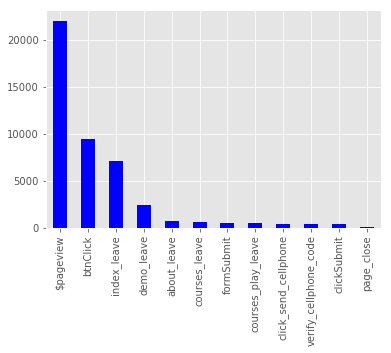

In [46]:
ax = df.event.value_counts().plot.bar(rot=0, color="b", figsize=(6,4))
ax.set_xticklabels(df.event.value_counts().index,rotation=90)
plt.show()

In [22]:
df.loc[df['event']=='$pageview',:].isnull().sum()

_nocache                                   0
distinct_id                                0
event                                      0
jssdk_error                            22025
lib.$lib                                   0
lib.$lib_method                            0
lib.$lib_version                           0
properties.$browser                        0
properties.$browser_version                0
properties.$first_browser_language     22037
properties.$first_referrer             22037
properties.$first_referrer_host        22037
properties.$first_visit_time           22037
properties.$ip                             0
properties.$is_first_day                   0
properties.$is_first_time                  0
properties.$latest_referrer             8824
properties.$latest_referrer_host        8824
properties.$latest_utm_campaign         9223
properties.$latest_utm_content          9628
properties.$latest_utm_medium           9253
properties.$latest_utm_source           9024
properties

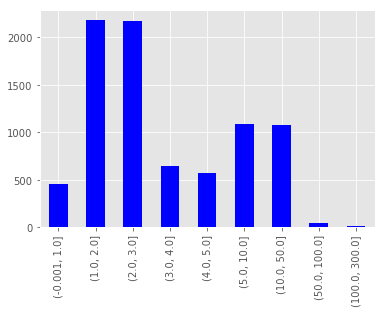

In [77]:
# The distuibution of user's record number
user = pd.Series(df.distinct_id).value_counts()
out = pd.cut(user, bins=[0, 1,2,3,4,5, 10, 50,100,300], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
ax.set_xticklabels([c for c in out.cat.categories],rotation=90)
plt.show()

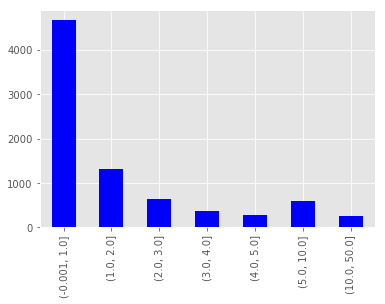

In [78]:
# The distuibution of user's pageview record number
user = (df.groupby(['event','distinct_id'])['_nocache'].count())['$pageview']
out = pd.cut(user, bins=[0, 1,2,3,4,5, 10, 50], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
ax.set_xticklabels([c for c in out.cat.categories],rotation=90)
plt.show()

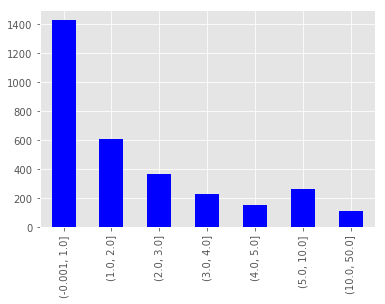

In [79]:
# The distuibution of user's btnClick record number
user = (df.groupby(['event','distinct_id'])['_nocache'].count())['btnClick']
out = pd.cut(user, bins=[0, 1,2,3,4,5, 10, 50], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
ax.set_xticklabels([c for c in out.cat.categories],rotation=90)
plt.show()

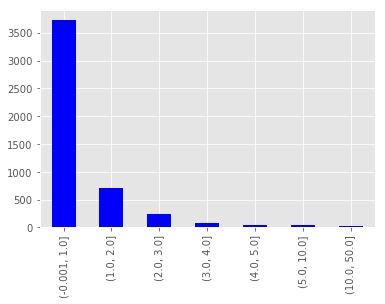

In [80]:
# The distuibution of user's index_leave record number
user = (df.groupby(['event','distinct_id'])['_nocache'].count())['index_leave']
out = pd.cut(user, bins=[0, 1,2,3,4,5, 10, 50], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
ax.set_xticklabels([c for c in out.cat.categories],rotation=90)
plt.show()

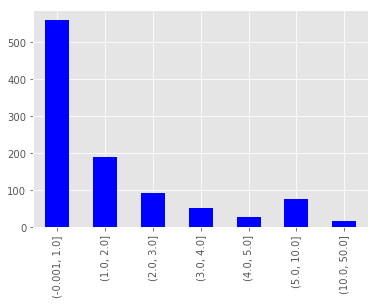

In [81]:
# The distuibution of user's demo_leave record number
user = (df.groupby(['event','distinct_id'])['_nocache'].count())['demo_leave']
out = pd.cut(user, bins=[0, 1,2,3,4,5, 10, 50], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
ax.set_xticklabels([c for c in out.cat.categories],rotation=90)
plt.show()

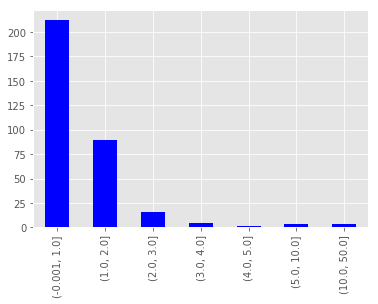

In [82]:
# The distuibution of user's formSubmit record number
user = (df.groupby(['event','distinct_id'])['_nocache'].count())['formSubmit']
out = pd.cut(user, bins=[0, 1,2,3,4,5, 10, 50], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
ax.set_xticklabels([c for c in out.cat.categories],rotation=90)
plt.show()

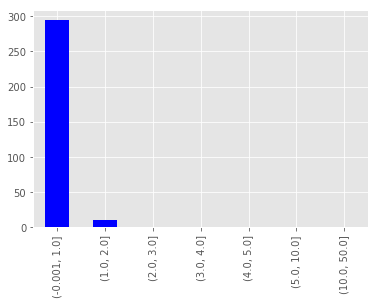

In [83]:
# The distuibution of user's clickSubmit record number
user = (df.groupby(['event','distinct_id'])['_nocache'].count())['clickSubmit']
out = pd.cut(user, bins=[0, 1,2,3,4,5, 10, 50], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
ax.set_xticklabels([c for c in out.cat.categories],rotation=90)
plt.show()

    4. jssdk_error
        - There are 33 not null values
        - What would be the effect of cookieNotEnable

In [95]:
df.jssdk_error.describe()

count                  33
unique                  1
top       cookieNotEnable
freq                   33
Name: jssdk_error, dtype: object

In [120]:
df[df.jssdk_error.notnull()].event.value_counts()

$pageview        12
btnClick          4
index_leave       3
about_leave       2
courses_leave     1
Name: event, dtype: int64

In [121]:
df[df.jssdk_error.notnull()].type.value_counts()

track               22
profile_set_once    11
Name: type, dtype: int64

In [100]:
df[df.jssdk_error.notnull()].distinct_id.value_counts()

539f2fd097b5df63aab29a1d87d8a2cae45b2c93    4
798310a4ed341fb3d0608a84565396ba8c797762    4
8aaa36e2cfa76f0b6dca677c114b16a3f654fdba    4
ee432c111ddb96197da6dd942ab61f8a099c1aeb    4
d51fa9da3631adf4efe2589d9b805bc782d0b47c    2
feb4b0eb9fe5974c76ec8732b6d4f8e4d9e941a8    2
60e4ed42eb86ac0ebf538d9439b490cf49ac3b4b    2
53098998df284093c04a628670103a73a18a9143    2
2f83e8e4396b4aa5edbddbc8b6c02546afdd7240    2
7d6f0aa1cf967361c65086fd79eb0ebee6d7480c    2
038508a50e6a5ef6653fb6f57fa25ff5c3e28951    2
c21c894455557fbbab333eaf3db0084b81c3105d    2
f2c8d81b8df07e796968ce954d3cee63376af0de    1
Name: distinct_id, dtype: int64

In [126]:
df[df.jssdk_error.notnull()].distinct_id.unique().size

13

In [132]:
df[df.jssdk_error.notnull()].distinct_id.unique()

array([u'c21c894455557fbbab333eaf3db0084b81c3105d',
       u'feb4b0eb9fe5974c76ec8732b6d4f8e4d9e941a8',
       u'f2c8d81b8df07e796968ce954d3cee63376af0de',
       u'038508a50e6a5ef6653fb6f57fa25ff5c3e28951',
       u'53098998df284093c04a628670103a73a18a9143',
       u'2f83e8e4396b4aa5edbddbc8b6c02546afdd7240',
       u'd51fa9da3631adf4efe2589d9b805bc782d0b47c',
       u'60e4ed42eb86ac0ebf538d9439b490cf49ac3b4b',
       u'798310a4ed341fb3d0608a84565396ba8c797762',
       u'539f2fd097b5df63aab29a1d87d8a2cae45b2c93',
       u'8aaa36e2cfa76f0b6dca677c114b16a3f654fdba',
       u'ee432c111ddb96197da6dd942ab61f8a099c1aeb',
       u'7d6f0aa1cf967361c65086fd79eb0ebee6d7480c'], dtype=object)

In [138]:
# All their records are have jssdk_error cookieNotEnable
df.set_index('distinct_id').loc[df[df.jssdk_error.notnull()].distinct_id.unique(),:].shape

(33, 7)

    5. lib

In [158]:
# import ast
# from pandas.io.json import json_normalize

# def only_dict(d):
#     '''
#     Convert json string representation of dictionary to a python dict
#     '''
#     return ast.literal_eval(d)

# # lib = json_normalize(df['lib'].apply(only_dict).tolist()).add_prefix('lib.')
# properties = json_normalize(df['properties'].apply(only_dict).tolist()).add_prefix('properties.')

In [36]:
df['lib.$lib_method'].value_counts(), df[u'lib.$lib_version'].value_counts(), df[u'lib.$lib'].value_counts()

(code    51048
 Name: lib.$lib_method, dtype: int64, 1.6.20    51048
 Name: lib.$lib_version, dtype: int64, js    51048
 Name: lib.$lib, dtype: int64)

    5. properties
    

In [39]:
df.loc[df_clean['event']=='index_leave',:].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7115 entries, 0 to 51040
Data columns (total 47 columns):
_nocache                              7115 non-null object
distinct_id                           7115 non-null object
event                                 7115 non-null object
time                                  7115 non-null int64
type                                  7115 non-null object
properties_$utm_medium                0 non-null object
properties_pagePosition               7115 non-null float64
properties_$is_first_day              7115 non-null object
properties_$screen_width              7115 non-null float64
properties_$url                       0 non-null object
properties_$browser                   7115 non-null object
properties_$utm_source                0 non-null object
properties_$referrer                  0 non-null object
properties_pageStayTime               7115 non-null float64
properties_$latest_utm_source         5088 non-null object
properties__sessi

In [40]:
df.loc[df_clean['event']=='btnClick',:].isnull().sum()

_nocache                                 0
distinct_id                              0
event                                    0
time                                     0
type                                     0
properties_$utm_medium                9392
properties_pagePosition               9392
properties_$is_first_day                 0
properties_$screen_width                 0
properties_$url                       9392
properties_$browser                      0
properties_$utm_source                9392
properties_$referrer                  9392
properties_pageStayTime               9392
properties_$latest_utm_source         3422
properties__session_referrer             0
properties_$is_first_time                0
properties_$first_referrer_host       9392
properties_$screen_height                0
properties_$lib                          0
properties_$utm_content               9392
properties_pageUrl                       0
properties_$latest_utm_medium         3519
properties_

In [47]:
df.loc[df_clean['event']=='$pageview',:].isnull().sum()

_nocache                                   0
distinct_id                                0
event                                      0
jssdk_error                            22013
lib.$lib                                   0
lib.$lib_method                            0
lib.$lib_version                           0
properties.$browser                        0
properties.$browser_version                0
properties.$first_browser_language     22025
properties.$first_referrer             22025
properties.$first_referrer_host        22025
properties.$first_visit_time           22025
properties.$ip                             0
properties.$is_first_day                   0
properties.$is_first_time                  0
properties.$latest_referrer             8819
properties.$latest_referrer_host        8819
properties.$latest_utm_campaign         9221
properties.$latest_utm_content          9626
properties.$latest_utm_medium           9251
properties.$latest_utm_source           9022
properties

In [48]:
df.loc[df_clean['event']=='index_leave',:].isnull().sum()

_nocache                                  0
distinct_id                               0
event                                     0
jssdk_error                            7112
lib.$lib                                  0
lib.$lib_method                           0
lib.$lib_version                          0
properties.$browser                       0
properties.$browser_version               0
properties.$first_browser_language     7115
properties.$first_referrer             7115
properties.$first_referrer_host        7115
properties.$first_visit_time           7115
properties.$ip                            0
properties.$is_first_day                  0
properties.$is_first_time                 0
properties.$latest_referrer            1878
properties.$latest_referrer_host       1878
properties.$latest_utm_campaign        2103
properties.$latest_utm_content         2212
properties.$latest_utm_medium          2109
properties.$latest_utm_source          2027
properties.$latest_utm_term     

    6. type
        - profile_set_once when a user first visit the website
        - is this count all the users 6485? rather than distict_id 8259

In [168]:
df.type.value_counts()

track               44563
profile_set_once     6485
Name: type, dtype: int64

    7. time

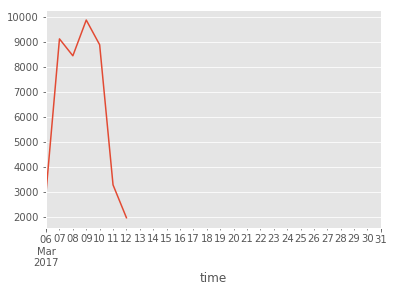

In [75]:
df_timestamp =pd.DataFrame(df['time'].copy())
df_timestamp = df_timestamp.set_index('time')
df_timestamp['count'] = 1
df_timestamp['count'].resample("1D").sum().plot()

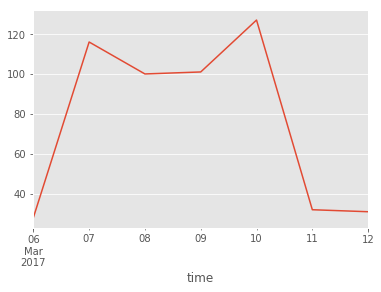

In [76]:
df_timestamp = pd.DataFrame(df.loc[df['event']=='formSubmit',"time"].copy())
df_timestamp
df_timestamp = df_timestamp.set_index('time')
df_timestamp['count'] = 1
df_timestamp['count'].resample("1D").sum().plot()

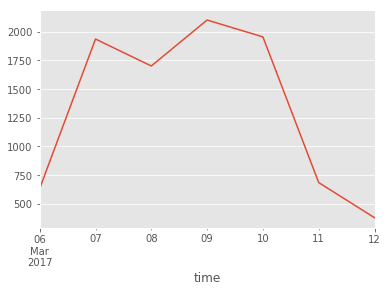

In [71]:
df_timestamp = pd.DataFrame(df.loc[df['event']=='btnClick',"time"].copy())
df_timestamp
df_timestamp = df_timestamp.set_index('time')
df_timestamp['count'] = 1
df_timestamp['count'].resample("1D").sum().plot()

### A User who complete the formSubmit

In [84]:
(df.loc[df['event']=='formSubmit',:]).loc[:,'distinct_id'].iloc[0]

'05275c9a86246309de06ef9e9443dbecb2d9e432'

In [90]:
df.loc[df['distinct_id']==u'9939d3e087bca29c42334d96dccd25ca0e06652a',:]

,_nocache,distinct_id,event,jssdk_error,lib.$lib,lib.$lib_method,lib.$lib_version,properties.$browser,properties.$browser_version,properties.$first_browser_language,...,properties.referrerUrl,properties.requestBtn,properties.result,properties.session_page_url,properties.siteUrl,properties.site_url,properties.url_path,properties.verification_code,time,type
1,3040562711955,9939d3e087bca29c42334d96dccd25ca0e06652a,NaN,NaN,js,code,1.6.20,NaN,NaN,zh-CN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-31 19:04:56.645000+08:00,profile_set_once
2,9587552771961,9939d3e087bca29c42334d96dccd25ca0e06652a,$pageview,NaN,js,code,1.6.20,chrome,56.0,NaN,...,NaN,NaN,NaN,https://sensorsdata.cn/?ch=demo,NaN,NaN,NaN,NaN,2017-03-06 17:04:10.856000+08:00,track
3,652937076129,9939d3e087bca29c42334d96dccd25ca0e06652a,btnClick,NaN,js,code,1.6.20,chrome,56.0,NaN,...,NaN,2.0,NaN,https://sensorsdata.cn/?ch=demo,NaN,NaN,NaN,NaN,2017-03-06 17:04:11.772000+08:00,track
4,8207407748558,9939d3e087bca29c42334d96dccd25ca0e06652a,btnClick,NaN,js,code,1.6.20,chrome,56.0,NaN,...,NaN,2.0,NaN,https://sensorsdata.cn/?ch=demo,NaN,NaN,NaN,NaN,2017-03-06 17:04:16.032000+08:00,track
8,6907472183771,9939d3e087bca29c42334d96dccd25ca0e06652a,btnClick,NaN,js,code,1.6.20,chrome,56.0,NaN,...,NaN,2.0,NaN,https://sensorsdata.cn/?ch=demo,NaN,NaN,NaN,NaN,2017-03-06 17:04:23.942000+08:00,track
17,2078298564543,9939d3e087bca29c42334d96dccd25ca0e06652a,click_send_cellphone,NaN,js,code,1.6.20,chrome,56.0,NaN,...,NaN,NaN,ajax success,https://sensorsdata.cn/?ch=demo,NaN,NaN,NaN,NaN,2017-03-06 17:05:14.336000+08:00,track
23,433821380624,9939d3e087bca29c42334d96dccd25ca0e06652a,verify_cellphone_code,NaN,js,code,1.6.20,chrome,56.0,NaN,...,NaN,NaN,正确,https://sensorsdata.cn/?ch=demo,NaN,NaN,NaN,NaN,2017-03-06 17:05:23.038000+08:00,track
25,811173513767,9939d3e087bca29c42334d96dccd25ca0e06652a,verify_cellphone_code,NaN,js,code,1.6.20,chrome,56.0,NaN,...,NaN,NaN,正确,https://sensorsdata.cn/?ch=demo,NaN,NaN,NaN,NaN,2017-03-06 17:05:23.125000+08:00,track
32,7825449252929,9939d3e087bca29c42334d96dccd25ca0e06652a,clickSubmit,NaN,js,code,1.6.20,chrome,56.0,NaN,...,NaN,2.0,NaN,https://sensorsdata.cn/?ch=demo,NaN,https://sensorsdata.cn/?ch=demo,NaN,9415,2017-03-06 17:05:43.422000+08:00,track
44,3866530543034,9939d3e087bca29c42334d96dccd25ca0e06652a,btnClick,NaN,js,code,1.6.20,chrome,56.0,NaN,...,NaN,NaN,NaN,https://sensorsdata.cn/?ch=demo,NaN,NaN,NaN,NaN,2017-03-06 17:05:54.028000+08:00,track


### A index_leave user

In [111]:
(df.loc[df['event']=='index_leave',:]).loc[:,'distinct_id'].iloc[5]

u'9357ebad253cd4e8343ae218552381d97144f81d'

In [132]:
a = df.loc[df['distinct_id']==u'9357ebad253cd4e8343ae218552381d97144f81d',:]

In [113]:
a

,_nocache,distinct_id,event,jssdk_error,lib,properties,time,type
51,3565409544598,9357ebad253cd4e8343ae218552381d97144f81d,NaN,NaN,"{u'$lib_method': u'code', u'$lib_version': u'1...","{u'$utm_medium': u'cpc', u'$utm_source': u'bai...",1490958296765,profile_set_once
52,0013197555060,9357ebad253cd4e8343ae218552381d97144f81d,$pageview,NaN,"{u'$lib_method': u'code', u'$lib_version': u'1...","{u'$utm_medium': u'cpc', u'$latest_referrer': ...",1488791159732,track
58,2317560421001,9357ebad253cd4e8343ae218552381d97144f81d,btnClick,NaN,"{u'$lib_method': u'code', u'$lib_version': u'1...",{u'$latest_referrer': u'https://www.baidu.com/...,1488791176847,track
59,3770060874789,9357ebad253cd4e8343ae218552381d97144f81d,index_leave,NaN,"{u'$lib_method': u'code', u'$lib_version': u'1...","{u'pagePosition': 2, u'$latest_referrer': u'ht...",1488791176847,track
60,5766813759789,9357ebad253cd4e8343ae218552381d97144f81d,$pageview,NaN,"{u'$lib_method': u'code', u'$lib_version': u'1...",{u'$latest_referrer': u'https://www.baidu.com/...,1488791177267,track
62,6501954101143,9357ebad253cd4e8343ae218552381d97144f81d,index_leave,NaN,"{u'$lib_method': u'code', u'$lib_version': u'1...","{u'pagePosition': 4, u'$latest_referrer': u'ht...",1488791183520,track


In [114]:
a.event.value_counts()

$pageview      2
index_leave    2
btnClick       1
Name: event, dtype: int64

In [129]:
a.iloc[0].properties

{u'$first_browser_language': u'en-US',
 u'$first_referrer': u'https://www.baidu.com/baidu.php',
 u'$first_referrer_host': u'www.baidu.com',
 u'$first_visit_time': u'2017-03-06 17:05:59.98',
 u'$utm_campaign': u'\u901a\u7528\u8bcd',
 u'$utm_content': u'\u901a\u7528-\u6570\u636e\u5206\u6790-\u4ea7\u54c1',
 u'$utm_medium': u'cpc',
 u'$utm_source': u'baidu',
 u'$utm_term': u'\u6570\u636e\u5206\u6790\u5e73\u53f0'}

In [133]:
a.iloc[1].properties

{u'$browser': u'chrome',
 u'$browser_version': u'56',
 u'$ip': u'58.132.182.130',
 u'$is_first_day': True,
 u'$is_first_time': True,
 u'$latest_referrer': u'https://www.baidu.com/baidu.php',
 u'$latest_referrer_host': u'www.baidu.com',
 u'$latest_utm_campaign': u'\u901a\u7528\u8bcd',
 u'$latest_utm_content': u'\u901a\u7528-\u6570\u636e\u5206\u6790-\u4ea7\u54c1',
 u'$latest_utm_medium': u'cpc',
 u'$latest_utm_source': u'baidu',
 u'$latest_utm_term': u'\u6570\u636e\u5206\u6790\u5e73\u53f0',
 u'$lib': u'js',
 u'$lib_version': u'1.6.20',
 u'$model': u'mac',
 u'$os': u'macosx',
 u'$os_version': u'10.12',
 u'$referrer': u'https://www.baidu.com/baidu.php',
 u'$referrer_host': u'www.baidu.com',
 u'$screen_height': 900,
 u'$screen_width': 1440,
 u'$title': u'\u795e\u7b56\u6570\u636e | Sensors Data - \u56fd\u5185\u9886\u5148\u7684\u7528\u6237\u884c\u4e3a\u5206\u6790\u4ea7\u54c1',
 u'$url': u'https://www.sensorsdata.cn/?utm_source=baidu&utm_medium=cpc&utm_term=%E6%95%B0%E6%8D%AE%E5%88%86%E6%9E%90

In [128]:
df.loc[df.event.isnull(),:]['type'].unique()

array([u'profile_set_once'], dtype=object)